### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
# transforms_train = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Grayscale(),
#     transforms.RandomHorizontalFlip(), # data augmentation
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
# ])

# transforms_val = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# data_dir = "drive/MyDrive/Research Internship papers/xai_filtered_data"
# train_datapath = data_dir + "/training"
# test_datapath = data_dir + "/test"

# # train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
# # val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)
# train_dataset = ImageFolder(train_datapath, transform=transforms_train)
# test_dataset = ImageFolder(test_datapath, transform=transforms_val)


# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

# print('Train dataset size:', len(train_dataset))
# print('Test dataset size:', len(test_dataset))

# class_names = train_dataset.classes
# print('Class names:', class_names)

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    # transforms.RandomHorizontalFlip(), # data augmentation
    # transforms.AutoAugmentPolicy,
    transforms.RandomOrder((
        # transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandAugment(),
        # transforms.TrivialAugmentWide()
    )),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
    # transforms.Normalize([0.485], [0.229])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.Normalize([0.485], [0.229])
])

data_dir = "drive/MyDrive/Research Internship papers/anime_dataset"
train_datapath = data_dir + "/training_data"
test_datapath = data_dir + "/test_data"

# train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
# val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)
train_dataset = ImageFolder(train_datapath, transform=transforms_train)
test_dataset = ImageFolder(test_datapath, transform=transforms_test)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 1466
Test dataset size: 368
Class names: ['female', 'male']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


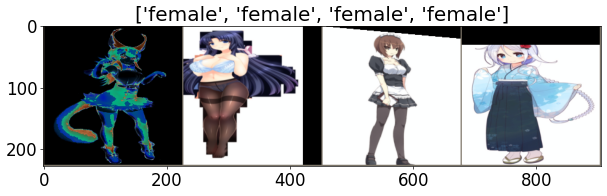

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [9]:
def get_model():
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
    model = model.to(device)
    return model


### <b>Training Phase</b>


In [10]:
# num_epochs = 10
# start_time = time.time()

# epoch_train_stats = []
# epoch_val_stats = []
# for epoch in range(num_epochs):
#     """ Training Phase """
#     model.train()

#     running_loss = 0.
#     running_corrects = 0

#     # load a batch data of images
#     for i, (inputs, labels) in enumerate(train_dataloader):
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # forward inputs and get output
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # get loss value and update the network weights
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(train_dataset)
#     epoch_acc = running_corrects / len(train_dataset) * 100.
#     epoch_train_stats.append({
#         "epoch_loss": epoch_loss,
#         "epoch_acc": epoch_acc
#     })
#     print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#     """ Validation Phase """
#     model.eval()

#     with torch.no_grad():
#         running_loss = 0.
#         running_corrects = 0

#         for inputs, labels in val_dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(val_dataset)
#         epoch_acc = running_corrects / len(val_dataset) * 100.
#         epoch_val_stats.append({
#             "epoch_loss": epoch_loss,
#             "epoch_acc": epoch_acc
#         })
#         print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

In [11]:
def train_epoch(model, device, dataloader, loss_function, optimizer):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

def validation_epoch(model, device, dataloader, loss_function):
    model.eval()
    running_loss = 0.
    running_corrects = 0
    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    return running_loss, running_corrects

In [ ]:
from sklearn.model_selection import KFold
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, ConcatDataset

torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

# dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs = 10
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=42)
batch_size = 128

history = {"train_loss": [], "val_loss": [], "train_accuracies": [], "val_accuracies": []}
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):
    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        train_epoch_loss = train_loss / len(train_loader.sampler)
        train_epoch_acc = train_correct / len(train_loader.sampler) * 100.

        val_loss, val_correct = validation_epoch(model, device, val_loader, criterion)
        val_epoch_loss = val_loss / len(val_loader.sampler)
        val_epoch_acc = val_correct / len(val_loader.sampler) * 100.
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,

                                                                                                             num_epochs,
                                                                                                             train_epoch_loss,
                                                                                                             val_epoch_loss,
                                                                                                             train_epoch_acc,
                                                                                                             val_epoch_acc))
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)
        history["train_accuracies"].append(train_epoch_acc)
        history["val_accuracies"].append(val_epoch_acc)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.8MB/s]


Fold 1


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:1/10 AVG Training Loss:0.683 AVG Test Loss:0.611 AVG Training Acc 57.76 % AVG Test Acc 66.67 %
Epoch:2/10 AVG Training Loss:0.589 AVG Test Loss:0.539 AVG Training Acc 69.80 % AVG Test Acc 72.11 %
Epoch:3/10 AVG Training Loss:0.518 AVG Test Loss:0.469 AVG Training Acc 76.88 % AVG Test Acc 82.99 %
Epoch:4/10 AVG Training Loss:0.457 AVG Test Loss:0.466 AVG Training Acc 79.86 % AVG Test Acc 77.55 %
Epoch:5/10 AVG Training Loss:0.411 AVG Test Loss:0.404 AVG Training Acc 80.89 % AVG Test Acc 81.97 %
Epoch:6/10 AVG Training Loss:0.380 AVG Test Loss:0.366 AVG Training Acc 83.87 % AVG Test Acc 85.37 %
Epoch:7/10 AVG Training Loss:0.347 AVG Test Loss:0.349 AVG Training Acc 85.49 % AVG Test Acc 84.01 %
Epoch:8/10 AVG Training Loss:0.317 AVG Test Loss:0.338 AVG Training Acc 87.97 % AVG Test Acc 87.07 %
Epoch:9/10 AVG Training Loss:0.280 AVG Test Loss:0.353 AVG Training Acc 89.33 % AVG Test Acc 82.65 %
Epoch:10/10 AVG Training Loss:0.269 AVG Test Loss:0.323 AVG Training Acc 90.53 % AVG Test A

In [ ]:
# avg_train_loss = np.mean(history['train_loss'].data.cpu().numpy())
# avg_test_loss = np.mean(history['val_loss'].data.cpu().numpy())
# avg_train_acc = np.mean(history['train_accuracies'].data.cpu().numpy())
# avg_test_acc = np.mean(history['val_accuracies'].data.cpu().numpy())

avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['val_loss'])
print(history['train_accuracies'])
avg_train_acc = np.mean([item.data.cpu().numpy() for item in history['train_accuracies']])
avg_test_acc = np.mean([item.data.cpu().numpy() for item in history['val_accuracies']])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))


### <b>Final Validation Phase</b>

* Save the trained model file.

In [17]:
save_path = 'face_gender_classification_transfer_learning_with_ResNet18.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [18]:
def get_model():
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
    model.load_state_dict(torch.load(save_path))
    model.to(device)

    return model

* Evaluate the trained model.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Prediction Result Examples]


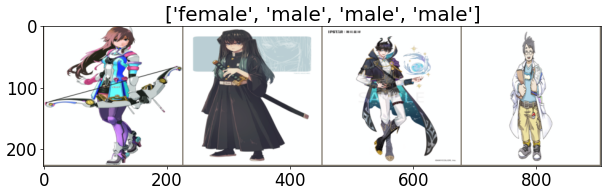

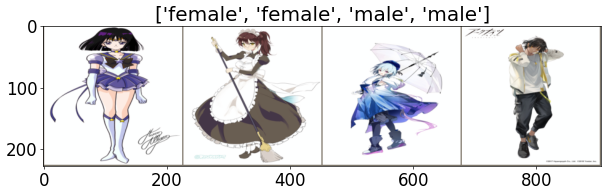

[Validation #9] Loss: 0.3558 Acc: 83.6956% Time: 67.1133s


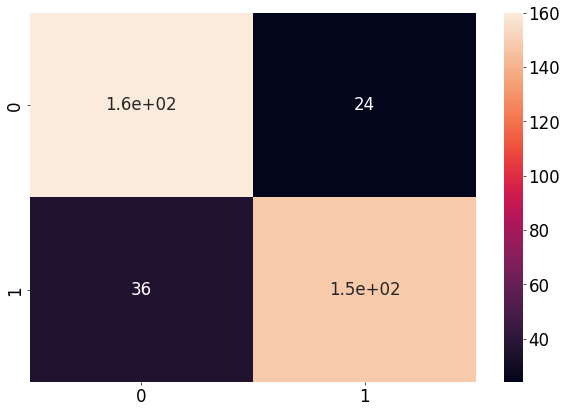

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
start_time = time.time()

y_pred = []
y_true = []

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        y_pred.extend(preds.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True)